# Loading in xray data from exp (55Fe x-rays on SCA 20663)

In [1]:
# %%
%matplotlib widget  
# Turn ON notebook and OFF inline and ipympl when running on OSC
#%matplotlib notebook
#%matplotlib inline 
%matplotlib ipympl

import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import scipy.optimize as opt
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.contrib.concurrent import thread_map
from astropy.io import fits
from scipy.stats import nbinom
from scipy.spatial import ConvexHull
from scipy.optimize import curve_fit
from scipy.ndimage import sum as ndi_sum
from scipy.ndimage import maximum_filter
from scipy.ndimage import binary_dilation
from astropy.stats import sigma_clipped_stats
from matplotlib.patches import Polygon, Rectangle
from scipy.ndimage import binary_dilation, label, center_of_mass
from concurrent.futures import ThreadPoolExecutor, as_completed
from scipy.ndimage import label
from pathlib import Path

try:
    here = Path(__file__).parent
except NameError:
    # __file__ doesn't exist in notebooks or interactive sessions
    here = Path.cwd()
fits_path = here / '20190919_95k_1p1m0p1_fe55_20663_003_diff.fits'  # ← replace with your actual filename

with fits.open(fits_path) as hdulist:
    # hdulist is a list of HDU (Header/Data Unit) objects
    primary_hdu = hdulist[0]
    data = primary_hdu.data      # NumPy array of your image/spectrum/whatever
    header = primary_hdu.header  # FITS header metadata

gain_array      = np.loadtxt('Select_20663X_summary.txt')[:, 5].reshape((32, 32))
supercell_size  = 128   # pixels per supercell

# Zac's Code: Adding in flats data to be used to find non-responsive pixels
flats_path = here / 'cflat-20663.fits' # ← replace with your actual flats filename

with fits.open(flats_path) as hdulist_flats:
    primary_hdu_flats = hdulist_flats[0]
    flats_data = primary_hdu_flats.data  # NumPy array of flats data
    flats_header = primary_hdu_flats.header  # FITS header metadata for flats


print(f"Data shape: {data.shape}")
print("Header keys:", list(header.keys())[:10])
print(f"Flats data shape: {flats_data.shape}")


Data shape: (100, 4096, 4096)
Header keys: ['SIMPLE', 'BITPIX', 'NAXIS', 'NAXIS1', 'NAXIS2', 'NAXIS3', 'EXTEND']
Flats data shape: (4096, 4096)


In [2]:
#enter number of available cores
num_of_cores = os.cpu_count() + 4

#X-ray energy (in eV)
xray_en = 5898.75

#data dimensions
Nframe, h, w = data.shape

def compute_mask_med_frame(data, sigma_mult):
    print("⏳ Finding hot pixels…")
    median_img = np.median(data, axis=0)
    mad        = np.median(np.abs(median_img - np.median(median_img)))
    sigma_est  = 1.4826 * mad
    thresh_med = np.median(median_img) + sigma_mult * sigma_est
    mask_med   = median_img > thresh_med
    print(f"✅ Done looking for hot pixels (σ={sigma_est:.3f}, thresh={thresh_med:.1f})")
    return mask_med

def compute_mask_first_frame(data, sigma_mult):
    print("⏳ Finding very hot pixels…")
    first_img  = data[0]
    med_first  = np.median(first_img)
    mad_first  = np.median(np.abs(first_img - med_first))
    sigma_est  = 1.4826 * mad_first
    thresh0    = med_first + sigma_mult * sigma_est
    mask0      = first_img > thresh0
    print(f"✅ Done looking for very hot pixels (σ={sigma_est:.3f}, thresh={thresh0:.1f})")
    return mask0

# Non-responsive pixels are found using flats data 
def compute_mask_no_response(flats_data, flat_tresh= .1):
    print("⏳ Finding non-responsive pixels…")
    flats_median = np.median(flats_data, axis=0) if flats_data.ndim == 3 else flats_data
    median_val = np.median(flats_median)
    threshold = flat_tresh * median_val
    mask_non_res = flats_median < threshold
    print(f"✅ Done looking for non-responsive pixels (median = {median_val:.1f}, threshold = {threshold:.1f})")
    return mask_non_res

# parameters
sigma_mult = 9.8
sat_cut     = 5.999

print(f"Number of cores available for parallelization = {num_of_cores - 4}")


# 1) prepare tasks as (fn, arg) pairs
tasks = [
    (compute_mask_med_frame,   sigma_mult),
    (compute_mask_first_frame, sigma_mult),
    (lambda data, _: compute_mask_no_response(flats_data), None),  # lambda to pass flats_data,
]

# 2) helper to call each fn with (data, param)
def _run_mask(fn, param):
    return fn(data, param)

# 3) run all three in parallel with a single tqdm bar
mask_hot, mask_veryhot, mask_non_res = thread_map(
    _run_mask,                          # worker that calls fn(data, param)
    [fn for fn, _ in tasks],           # list of your 3 functions
    ([param for _, param in tasks]),     # their corresponding single argument
    max_workers=num_of_cores,
    desc="Computing all masks",
    unit="mask",
    tqdm_class = tqdm
)

print("🔗 Combining masks into one boolean array…")
base_mask = mask_hot | mask_veryhot | mask_non_res

# create a mask for pixels adjacent to a pixel with flagged response: any neighbor of the base_mask
print("⏳ Finding all adjacent pixels…")
mask_adj  = binary_dilation(base_mask, structure=np.ones((3,3)), border_value=0) & ~base_mask
print("✅ Done with adjacent pixel mask")

print("🔗 Combining all masks into final array…")
maskArray = base_mask | mask_adj
print("🎉 maskArray ready, shape =", maskArray.shape)

print("Comparing to percentages from Hirata, 2024, Table 2:")
# fractions in percent
frac_non_res   = mask_non_res.mean()   * 100  # mask.mean() = mask.sum() / mask.size
frac_hot   = mask_hot.mean()   * 100  
frac_veryhot = mask_veryhot.mean()       * 100  
frac_adj = mask_adj.mean() * 100
frac_all   = maskArray.mean()   * 100  # union 

print(f"Non-resp pixels: {frac_non_res:.2f}% (vs. 0.53%)")
print(f"Hot pixels: {frac_hot:.2f}% (vs. 0.20%)")
print(f"Very hot pixels: {frac_veryhot:.2f}% (vs. 0.11%)")
print(f"Adjacent pixels: {frac_adj:.2f}% (vs. 2.47%)")
print(f"Union:       {frac_all:.2f}%  (vs. 3.01%)")

Number of cores available for parallelization = 20
⏳ Finding hot pixels…
⏳ Finding very hot pixels…
⏳ Finding non-responsive pixels…


Computing all masks:   0%|          | 0/3 [00:00<?, ?mask/s]

✅ Done looking for non-responsive pixels (median = 1.0, threshold = 0.1)
✅ Done looking for very hot pixels (σ=8.896, thresh=86.2)


Computing all masks: 100%|██████████| 3/3 [00:49<00:00, 16.62s/mask]

✅ Done looking for hot pixels (σ=0.741, thresh=7.3)
🔗 Combining masks into one boolean array…
⏳ Finding all adjacent pixels…
✅ Done with adjacent pixel mask
🔗 Combining all masks into final array…
🎉 maskArray ready, shape = (4096, 4096)
Comparing to percentages from Hirata, 2024, Table 2:


Non-resp pixels: 0.40% (vs. 0.53%)
Hot pixels: 0.40% (vs. 0.20%)
Very hot pixels: 0.11% (vs. 0.11%)
Adjacent pixels: 2.95% (vs. 2.47%)
Union:       3.77%  (vs. 3.01%)


Number of very hot pixels =  17769
Number of hot pixels =  66476
Number of non-responsive pixels =  66858
Number of adjacent pixels =  495696
Total number of unusable pixels =  633217


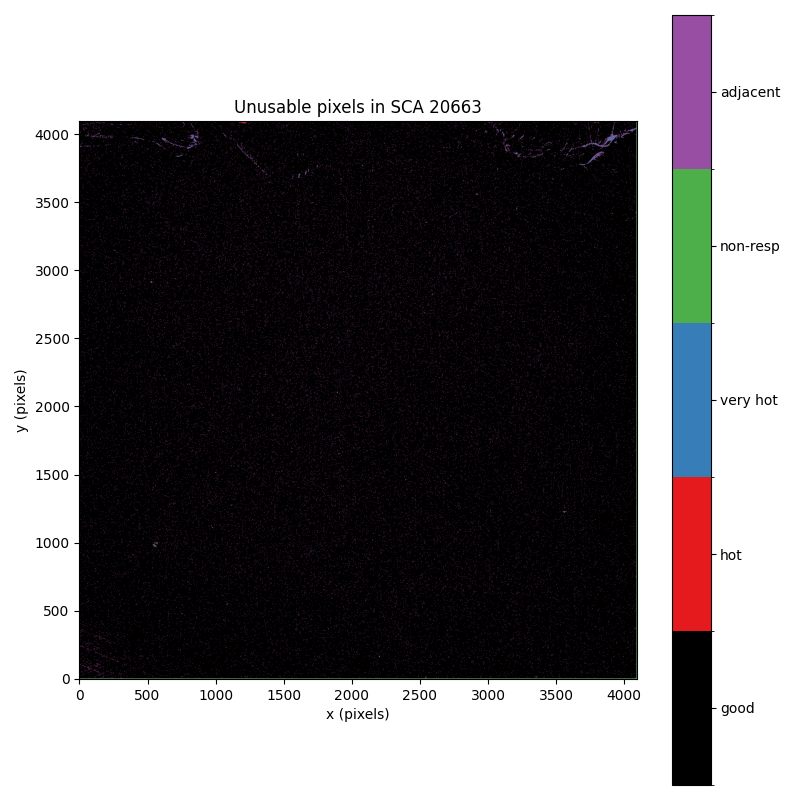

In [16]:
very_hot_pix = np.count_nonzero(mask_veryhot)
hot_pix = np.count_nonzero(mask_hot)
non_res_pix = np.count_nonzero(mask_non_res)
adj_pix = np.count_nonzero(mask_adj)
all_bad_pix = np.count_nonzero(maskArray)

print("Number of very hot pixels = ", very_hot_pix)
print("Number of hot pixels = ", hot_pix)
print("Number of non-responsive pixels = ", non_res_pix)
print("Number of adjacent pixels = ", adj_pix)
print("Total number of unusable pixels = ", all_bad_pix)

labels = np.zeros((h, w), dtype=int)
labels[mask_hot]     = 1
labels[mask_veryhot] = 2
labels[mask_non_res] = 3
labels[mask_adj]     = 4

cmap = mpl.colors.ListedColormap([
    "#000000",  # 0 = good pixels (black) 
    "#e41a1c",  # 1 = hot         (red)
    "#377eb8",  # 2 = very hot    (blue)
    "#4daf4a",  # 3 = non-resp    (green)
    "#984ea3",  # 4 = adjacent    (purple)
])
# make boundaries at ints 0–5
norm = mpl.colors.BoundaryNorm(np.arange(6), cmap.N)

plt.figure(figsize=(8, 8))
im = plt.imshow(labels, origin="lower", cmap=cmap, norm=norm)
cbar = plt.colorbar(im, ticks=[0.5,1.5,2.5,3.5,4.5])
cbar.ax.set_yticklabels([
    "good", "hot", "very hot", "non-resp", "adjacent"
])
plt.title("Unusable pixels in SCA 20663")
plt.xlabel("x (pixels)")
plt.ylabel("y (pixels)")
plt.tight_layout()
plt.show()

Verifying single-event occurrence: 100%|██████████| 100/100 [00:00<00:00, 2611.47frame/s]


Found 62239 x-ray & cosmic-ray-like peaks with ≥4.8 σ cut


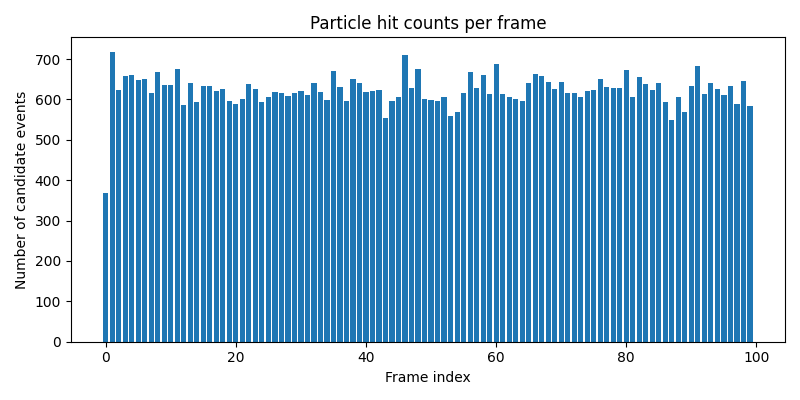

In [17]:
sigma_thresh  = 4.85
mask_expanded = maximum_filter(maskArray.astype(int), size=5) > 0

def find_peaks_for_frame(iframe, sigma_thresh):
    image   = data[iframe]
    _, med, _ = sigma_clipped_stats(image, sigma=3.0, maxiters=5)
    mad     = np.median(np.abs(image - med))
    sigma_e = mad * 1.4826
    threshold = med + sigma_thresh * sigma_e

    local_max = maximum_filter(image, size=3)
    cand      = (image == local_max) & (~mask_expanded) & (image > threshold)

    ys, xs = np.where(cand)
    peaks  = [(iframe, int(y), int(x)) for y, x in zip(ys, xs)]
    return peaks, threshold

if __name__ == "__main__":

    # 1) run in parallel with a tqdm bar
    results = thread_map(
        find_peaks_for_frame,        # worker fn
        range(Nframe),               # first iterable
        [sigma_thresh] * Nframe,     # second iterable
        max_workers=num_of_cores,
        desc="Finding peaks",        # bar label
        unit="frame",
        tqdm_class = tqdm
    )

    # 2) unzip them into two lists
    all_frame_peaks, thresholds = zip(*results)

    # 3) previous-frame filtering
    filtered_events = []
    for f, peaks in tqdm(enumerate(all_frame_peaks),
                         total=Nframe,
                         desc='Verifying single-event occurrence',
                         unit='frame'):
        prev_f   = (f - 1) % Nframe
        prev_pos = {(y, x) for (_, y, x) in all_frame_peaks[prev_f]}
        for (_, y, x) in peaks:
            if (y, x) not in prev_pos:
                filtered_events.append((f, y, x))

    events = np.array(filtered_events, dtype=int)
    print(f"Found {len(events)} x-ray & cosmic-ray-like peaks "
          f"with ≥{sigma_thresh:.1f} σ cut")

    # 4) counts per frame
    counts = np.bincount(events[:,0], minlength=Nframe)

    plt.figure(figsize=(8,4))
    plt.bar(np.arange(Nframe), counts)
    plt.xlabel("Frame index")
    plt.ylabel("Number of candidate events")
    plt.title("Particle hit counts per frame")
    plt.tight_layout()
    plt.show()


In [18]:
def merge_peaks(events, data, proximity_radius=2, max_workers=num_of_cores):
    """
    Merge spatially adjacent peaks within each frame.

    Parameters
    ----------
    events : (M, 3)-ndarray of int
        List of (frame, y, x) peaks you've already found.
    data : ndarray, shape (Nframe, h, w)
        Your full data cube, needed for intensity weighting.
    proximity_radius : int
        Merge any two peaks whose pixel-centers are within
        `proximity_radius` in Chebyshev distance.

    Returns
    -------
    merged : (K,3)-ndarray of int
        New list of (frame, y, x), one per merged object.
    """

    # Pre-bucket original peaks by frame for O(1) lookup
    events_by_frame = {
        f: events[events[:,0] == f, 1:]
        for f in np.unique(events[:,0])
    }

    # A 3×3 struct for the actual label() call
    small_struct = np.ones((3,3), dtype=bool)
    # The large footprint we use for dilation
    big_struct   = np.ones((2*proximity_radius+1,
                            2*proximity_radius+1), dtype=bool)

    def process_frame(f):
        coords = events_by_frame.get(f)
        if coords is None or len(coords)==0:
            return []

        # build a 1-pixel mask of your raw hits
        mask = np.zeros((h, w), bool)
        mask[coords[:,0], coords[:,1]] = True

        # dilate by the big_struct so any hits within r pixels merge
        mask_dil = binary_dilation(mask, structure=big_struct)

        # now label the dilated mask with the 3×3 struct
        labeled, ncomp = label(mask_dil, structure=small_struct)

        # figure out which original coords belong to which label
        labels_at_peaks = labeled[coords[:,0], coords[:,1]]

        merged = []
        for lab in range(1, ncomp+1):
            inds = np.where(labels_at_peaks == lab)[0]
            cluster = coords[inds]   # all (y,x) in this cluster

            if len(cluster)==1:
                y0, x0 = cluster[0]
            else:
                # intensity‐weighted centroid over the ORIGINAL points
                ys = cluster[:,0].astype(float)
                xs = cluster[:,1].astype(float)
                ws = data[f, ys.astype(int), xs.astype(int)].astype(float)
                y0 = int(round(np.average(ys, weights=ws)))
                x0 = int(round(np.average(xs, weights=ws)))

            merged.append((f, y0, x0))

        return merged

    # dispatch in parallel
    merged = []
    with ThreadPoolExecutor(max_workers=max_workers) as exe:
        for sub in exe.map(process_frame, range(Nframe)):
            merged.extend(sub)

    return np.array(merged, dtype=int)

merged_events = merge_peaks(events, data)
events_difference = len(events) -len(merged_events)

print(f"{len(events)} → {len(merged_events)} merged events, a difference of {events_difference}")

62239 → 61856 merged events, a difference of 383


In [19]:
def plot_mergers(frame, events, merged_events, data, proximity_radius=2):
    """
    Show original peaks vs. merged clusters for a single frame,
    drawing red circles on the raw hits, cyan x’s at merged centroids,
    and white rectangles around each dilated cluster (r=proximity_radius).
    """
    img = data[frame]

    # 1) pick out this frame’s original and merged points
    orig   = events[events[:,0] == frame][:, 1:]
    merged = merged_events[merged_events[:,0] == frame][:, 1:]

    # 2) build a 1-pixel mask of the raw hits
    mask = np.zeros((h, w), dtype=bool)
    for y, x in orig:
        mask[y, x] = True

    # 3) dilate by your big footprint
    big_struct = np.ones((2*proximity_radius+1,
                          2*proximity_radius+1), dtype=bool)
    mask_dil = binary_dilation(mask, structure=big_struct)

    # 4) label that dilated mask with a 3×3 struct
    small_struct = np.ones((3,3), dtype=bool)
    labeled, ncomp = label(mask_dil, structure=small_struct)

    # 5) plot background
    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(img, cmap='gray', origin='lower')

    # 6) overlay raw peaks
    if len(orig):
        ys, xs = orig[:,0], orig[:,1]
        ax.scatter(xs, ys,
                   s=30, facecolors='none', edgecolors='red',
                   label='orig peaks')

    # 7) overlay merged centroids
    if len(merged):
        ym, xm = merged[:,0], merged[:,1]
        ax.scatter(xm, ym,
                   s=60, marker='x', color='cyan',
                   label='merged centroids')

    # 8) draw white rectangles around each dilated cluster
    for lab in range(1, ncomp+1):
        coords = np.argwhere(labeled == lab)
        y0, y1 = coords[:,0].min(), coords[:,0].max()
        x0, x1 = coords[:,1].min(), coords[:,1].max()
        width  = x1 - x0 + 1
        height = y1 - y0 + 1

        rect = Rectangle((x0, y0),
                         width, height,
                         fill=False,
                         edgecolor='white',
                         linewidth=1)
        ax.add_patch(rect)

    ax.set_title(f'Frame {frame}: orig peaks & merged clusters (r={proximity_radius})')
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

#plot_mergers(frame=61, events=events, merged_events=merged_events, data=data)    

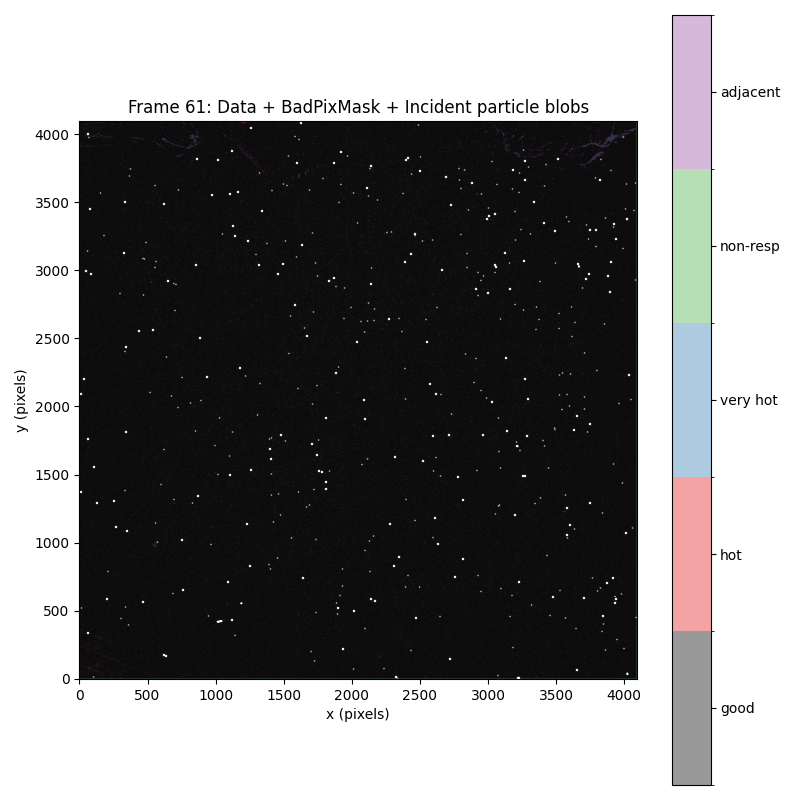

In [20]:
# parameters
frame = 61
proximity_radius = 2

# — build your 4-class mask label image as before —
labels = np.zeros((h, w),     dtype=int)
labels[mask_hot]     = 1
labels[mask_veryhot] = 2
labels[mask_non_res] = 3
labels[mask_adj]     = 4

cmap = mpl.colors.ListedColormap([
    "#000000",  # 0 good
    "#e41a1c",  # 1 hot
    "#377eb8",  # 2 very hot
    "#4daf4a",  # 3 non-resp
    "#984ea3",  # 4 adjacent
])
norm = mpl.colors.BoundaryNorm(np.arange(6), cmap.N)

# — reconstruct your dilated clusters for this frame —
orig = events[events[:,0] == frame][:,1:]   # (y,x) of raw hits
mask_peaks = np.zeros((h,w), bool)
mask_peaks[orig[:,0], orig[:,1]] = True

big_struct = np.ones((2*proximity_radius+1,)*2, dtype=bool)
mask_dil   = binary_dilation(mask_peaks, structure=big_struct)

# now label that with a 3×3
labeled, ncomp = label(mask_dil, structure=np.ones((3,3), bool))

# — plot everything —
fig, ax = plt.subplots(figsize=(8,8))

# 1) raw data
ax.imshow(data[frame], cmap='gray', origin='lower')

# 2) mask classes, semi-transparent
im = ax.imshow(labels, origin='lower', cmap=cmap, norm=norm, alpha=0.4)
cbar = fig.colorbar(im, ticks=[0.5,1.5,2.5,3.5,4.5], ax=ax)
cbar.ax.set_yticklabels(["good","hot","very hot","non-resp","adjacent"])

# 3) convex‐hull blobs (or tiny boxes for 1–2 pixel clusters)
for lab in range(1, ncomp+1):
    pts = np.argwhere(labeled == lab)  # array of [[y,x],...]
    if len(pts) >= 3:
        hull = ConvexHull(pts)
        hull_pts = pts[hull.vertices]      # still [[y,x],...]
        # flip to (x,y) for plotting
        poly = Polygon(hull_pts[:, ::-1],
                       fill=False, edgecolor='white', linewidth=1)
        ax.add_patch(poly)
    else:
        # fallback box
        y0, y1 = pts[:,0].min(), pts[:,0].max()
        x0, x1 = pts[:,1].min(), pts[:,1].max()
        rect = Rectangle((x0, y0),
                         x1-x0+1, y1-y0+1,
                         fill=False, edgecolor='white', linewidth=1)
        ax.add_patch(rect)

ax.set_title(f"Frame {frame}: Data + BadPixMask + Incident particle blobs")
ax.set_xlabel("x (pixels)")
ax.set_ylabel("y (pixels)")
plt.tight_layout()
plt.show()


In [ ]:
# Freudenburg et al. gain
gain = 1.6232  # electrons per DN

def prep_frame(f):
    img   = data[f].astype(np.float32)
    _, med, _ = sigma_clipped_stats(img, sigma=3.0, maxiters=15)
    return f, med

def process_hit(hit):
    f, y, x, blob_lab = hit.astype(int)
    img  = data[f].astype(np.int32)
    med  = medians[f]

    # pick per-supercell gain
    sc_row, sc_col = y // supercell_size, x // supercell_size
    sc_gain = gain_array[sc_row, sc_col]

    # 3×3 and 5×5 sums (DN → e⁻)
    y0, y1 = max(y-1,0), min(y+2,h)
    x0, x1 = max(x-1,0), min(x+2,w)
    sum3   = img[y0:y1, x0:x1].sum()
    y0_5, y1_5 = max(y-2,0), min(y+3,h)
    x0_5, x1_5 = max(x-2,0), min(x+3,w)
    sum5   = img[y0_5:y1_5, x0_5:x1_5].sum()

    # blob sums & counts (unchanged)
    s_arr      = blob_sums[f]
    c_arr      = blob_counts[f]
    sum_blob   = int(s_arr[blob_lab-1])
    n_pix_blob = int(c_arr[blob_lab-1])

    return {
      'frame':      f,
      'y':          y,
      'x':          x,
      'sum3x3_DN':  sum3,
      'sum3x3_e⁻':  sum3 * sc_gain,
      'sum5x5_DN':  sum5,
      'sum5x5_e⁻':  sum5 * sc_gain,
      'blob_label': blob_lab,
      'blob_DN':    sum_blob,
      'blob_e⁻':    sum_blob * sc_gain,
      'n_pix_blob': n_pix_blob,
    }

medians = np.zeros(Nframe, dtype=float)
median_results = thread_map(
    prep_frame,
    range(Nframe),
    max_workers=num_of_cores,
    desc="Computing frame medians",
    unit="frame",
    tqdm_class = tqdm
)

print('Task 1 of 3 complete, waiting for next task to begin...')

for f, med in median_results:
    medians[f] = med

# Build an index of which events live in each frame
# events is an (M,3) array: [frame, y, x]
event_idxs = {
    f: np.where(merged_events[:,0] == f)[0]
    for f in np.unique(merged_events[:,0])
}

# structuring elements
proximity_radius = 2  # or whatever you choose
big_struct   = np.ones((2*proximity_radius+1,)*2, dtype=bool)
small_struct = np.ones((3,3), dtype=bool)

# containers for per-frame blob sums/counts
blob_sums     = {}
blob_counts   = {}
hit_blob_label = np.zeros(len(merged_events), dtype=int)

# Frame‐by‐frame “blob” computation
for f, idxs in tqdm(event_idxs.items(), desc='Computing blobs in all frames',unit='frame'):
    # a) raw‐hit mask
    coords     = merged_events[idxs,1:].astype(int)  # (k,2)
    mask_peaks = np.zeros((h,w), bool)
    mask_peaks[coords[:,0], coords[:,1]] = True

    # b) dilate & label
    dil         = binary_dilation(mask_peaks, structure=big_struct)
    lab_img, n_blobs = label(dil, structure=small_struct)

    # c) background‐subtracted image
    img    = data[f].astype(np.float64)
    med    = medians[f]
    im_corr = img - med

    # d) sums & counts per blob‐label
    labels_idx    = np.arange(1, n_blobs+1)
    sums   = ndi_sum(im_corr, lab_img, labels_idx)
    counts = ndi_sum(np.ones_like(im_corr), lab_img, labels_idx).astype(int)

    blob_sums[f]   = sums
    blob_counts[f] = counts

    # e) assign each raw‐hit to a blob
    hit_blob_label[idxs] = lab_img[coords[:,0], coords[:,1]]

    
print('Task 2 of 3 complete, waiting for next task to begin...')

# augment events → events_aug with blob_label as 4th column
events_aug = np.column_stack((merged_events, hit_blob_label))

# Parallel hit‐processing over events_aug → DataFrame
rows = thread_map(
    process_hit,
    events_aug,
    max_workers=num_of_cores,
    desc="Processing hits",
    unit="hit",
    tqdm_class = tqdm
)

print('Task 3 of 3 complete, creating dataframe and printing head.')

df = pd.DataFrame(rows)
print(df.head())

Computing frame medians: 100%|██████████| 100/100 [00:40<00:00,  2.48frame/s]


Task 1 of 3 complete, waiting for next task to begin...


Computing blobs in all frames: 100%|██████████| 100/100 [01:23<00:00,  1.20frame/s]


Task 2 of 3 complete, waiting for next task to begin...


Processing hits:   9%|▉         | 5747/61856 [00:54<08:51, 105.54hit/s]]


In [9]:
def compute_read_noise(row):
    f, y, x = row
    f_noise = f - 2
    if f_noise < 0:
        return None

    # pull the image from two frames earlier
    img_noise = data[f_noise].astype(np.float64)

    # 3×3 window around (y,x)
    y0, y1 = max(y-1, 0), min(y+2, h)
    x0, x1 = max(x-1, 0), min(x+2, w)
    noise_dn = img_noise[y0:y1, x0:x1].sum()

    # per-supercell gain lookup
    sc_row, sc_col = y // supercell_size, x // supercell_size
    sc_gain = gain_array[sc_row, sc_col]

    return noise_dn * sc_gain

# gather coords once so we know total count
coords = df[['frame','y','x']].values.astype(int)

read_noise_e = []

with ThreadPoolExecutor(max_workers=num_of_cores) as executor:
    # executor.map keeps order, returns iterator of results
    for noise in tqdm(executor.map(compute_read_noise, coords),
                      total=len(coords),
                      desc="Computing read noise", unit="events"):
        if noise is not None:
            read_noise_e.append(noise)

read_noise_e = np.array(read_noise_e)
print("Done")

Computing read noise: 100%|██████████| 61556/61556 [02:58<00:00, 343.91events/s] 

Done


In [10]:
# make a full‐length array of NaNs
read_noise_full = np.full(len(df), np.nan)

# build a mask of which rows had f ≥ 2
mask_valid = df['frame'].values >= 2

# fill in only those slots, in order, with your computed noise
read_noise_full[mask_valid] = read_noise_e

# assign as a new column
df['read_noise_e'] = read_noise_full

# inspect
print(df.head())

   frame   y     x  sum3x3_DN   sum3x3_e⁻  sum5x5_DN   sum5x5_e⁻  blob_label  \
0      0  10   762         68  116.835070         68  116.835070           1   
1      0  10  3225        123  194.123483        141  222.531798           2   
2      0  12  3413         63  101.550916         24   38.686063           3   
3      0  16  3403         89  143.460818         61   98.327077           4   
4      0  71  3431         64  103.162835         99  159.580011           5   

   blob_DN     blob_e⁻  n_pix_blob  read_noise_e  
0       93  159.789140          25           NaN  
1      166  261.987790          25           NaN  
2       49   78.984046          25           NaN  
3       86  138.625060          25           NaN  
4      124  199.877993          25           NaN  


<IPython.core.display.Javascript object>


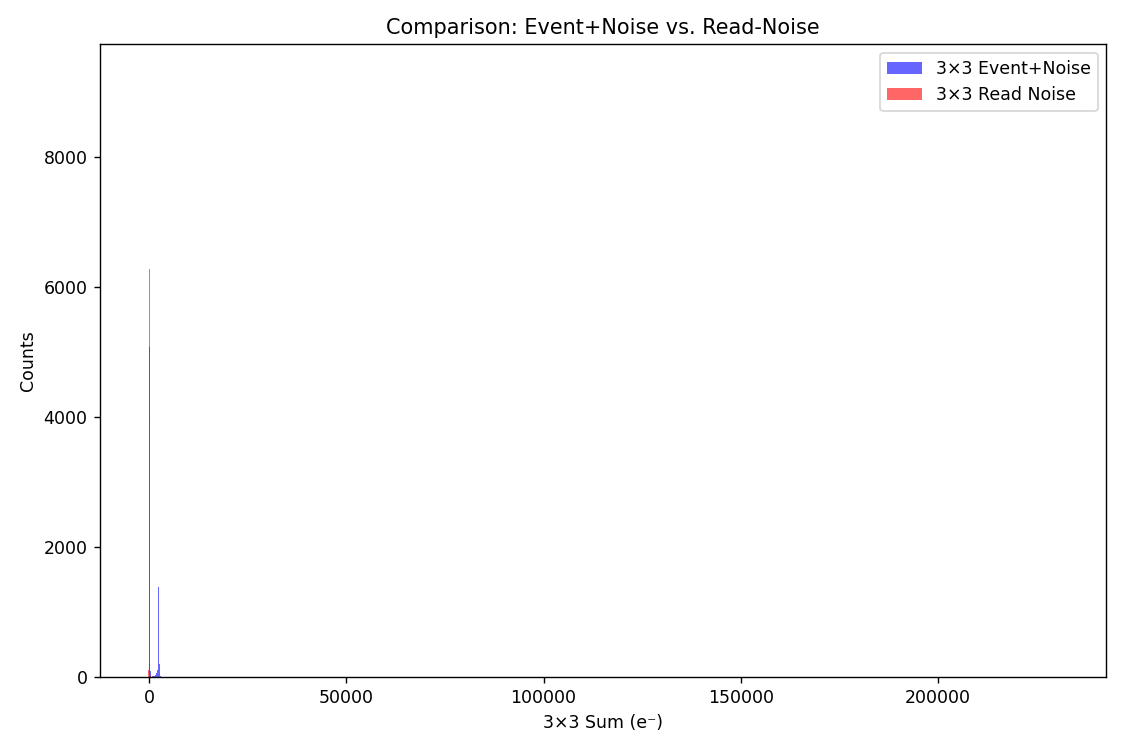

In [11]:
# plot histograms side‐by‐side
plt.figure(figsize=(9,6))

# use a common binning
bins = np.linspace(
    min(df['sum3x3_e⁻'].min(), read_noise_e.min()),
    max(df['sum3x3_e⁻'].max(), read_noise_e.max()),
    10000
)

plt.hist(df['sum3x3_e⁻'], bins=bins, color = 'b', alpha=0.6, label='3×3 Event+Noise')
plt.hist(read_noise_e,   bins=bins, color = 'r', alpha=0.6, label='3×3 Read Noise')

plt.xlabel('3×3 Sum (e⁻)')
plt.ylabel('Counts')
plt.title('Comparison: Event+Noise vs. Read-Noise')
plt.legend()
plt.tight_layout()
plt.show()

Read noise → μ = -0.54 e⁻, σ = 59.14 e⁻


<IPython.core.display.Javascript object>


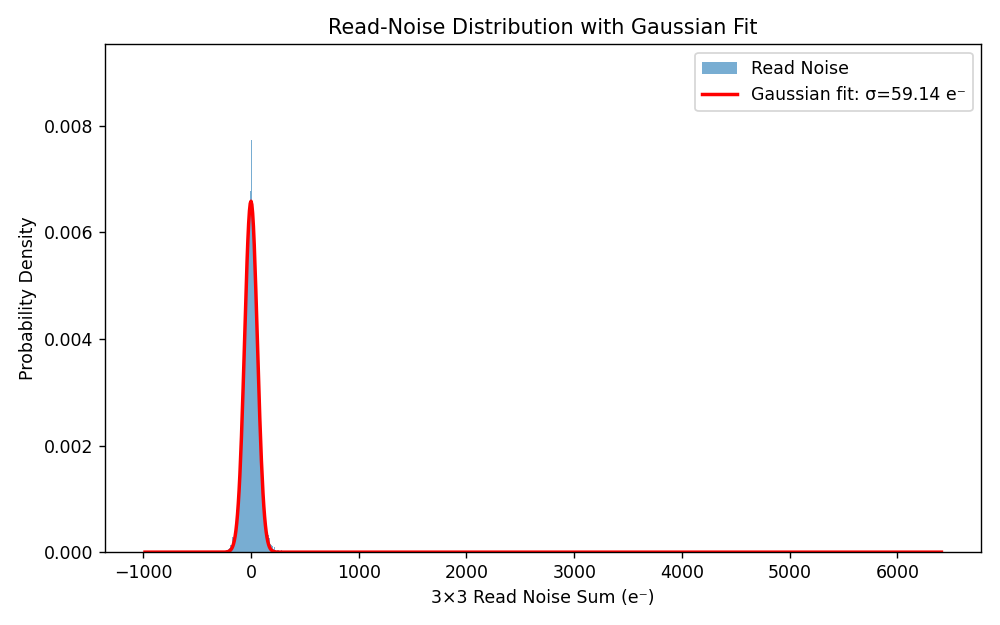

In [12]:
def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2)

# 1) grab your read-noise series (drop NaNs)
#read_noise = df['read_noise_e'].dropna().values
read_noise=read_noise_e
# 2) histogram parameters
num_of_bins = 4000   # or whatever binning you used before

# 3) build histogram
counts, bin_edges = np.histogram(read_noise, bins=num_of_bins, density=True)
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])

# 4) initial guess [A, μ, σ]
p0 = [counts.max(), read_noise.mean(), read_noise.std()]

# 5) fit
popt, _ = curve_fit(gaussian, bin_centers, counts, p0=p0)
A_fit, mu_fit, sigma_fit = popt
sigma_fit = abs(sigma_fit)

# 6) print out the σ
print(f"Read noise → μ = {mu_fit:.2f} e⁻, σ = {sigma_fit:.2f} e⁻")

# 7) plot histogram + fit
plt.figure(figsize=(8,5))
plt.hist(read_noise, bins=num_of_bins, density=True, alpha=0.6, label='Read Noise')
x_fit = np.linspace(bin_edges[0], bin_edges[-1], 1000)
plt.plot(x_fit, gaussian(x_fit, *popt), 'r-', lw=2,
         label=f'Gaussian fit: σ={sigma_fit:.2f} e⁻')
plt.xlabel('3×3 Read Noise Sum (e⁻)')
plt.ylabel('Probability Density')
plt.title('Read‐Noise Distribution with Gaussian Fit')
plt.legend()
plt.tight_layout()
plt.show()

read_noise_sigma = sigma_fit

<IPython.core.display.Javascript object>


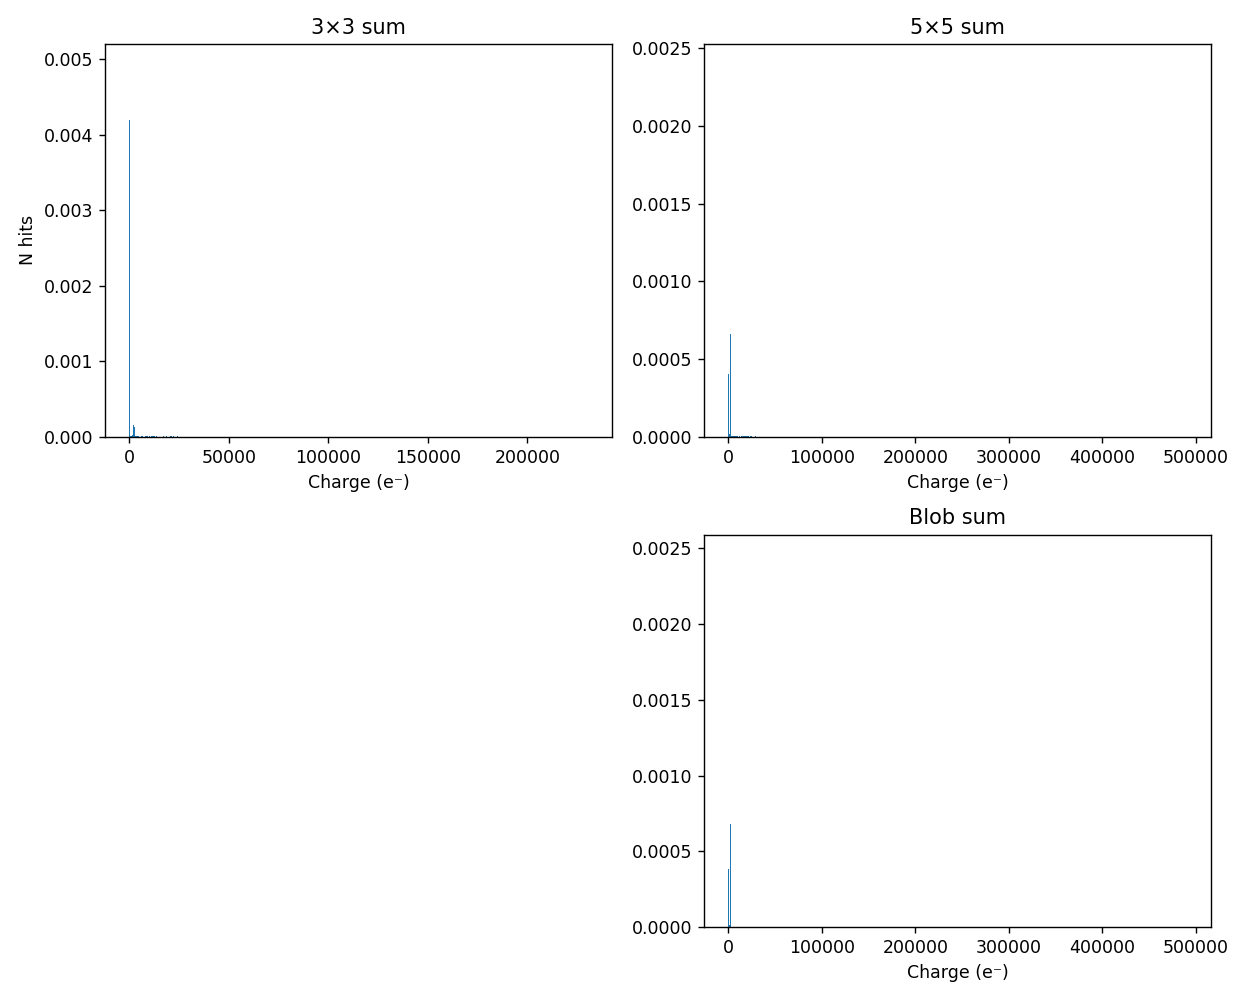

In [13]:
# Plot histograms in 2 rows × 2 cols ---
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()   # makes it easy to index: axes[0], axes[1], axes[2], axes[3]

# 3×3 sum
axes[0].hist(df['sum3x3_e⁻'], bins=10000, density = True)
axes[0].set(title='3×3 sum', xlabel='Charge (e⁻)', ylabel='N hits')

# 5×5 sum
axes[1].hist(df['sum5x5_e⁻'], bins=10000, density = True)
axes[1].set(title='5×5 sum', xlabel='Charge (e⁻)')

# Footprint sum
axes[2].axis('off')
#axes[2].hist(df['fp_e⁻'], bins=10000, density = True)
#axes[2].set(title='Footprint sum', xlabel='Charge (e⁻)')

# blob sum
axes[3].hist(df['blob_e⁻'], bins=10000, density = True)
axes[3].set(title='Blob sum', xlabel='Charge (e⁻)')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


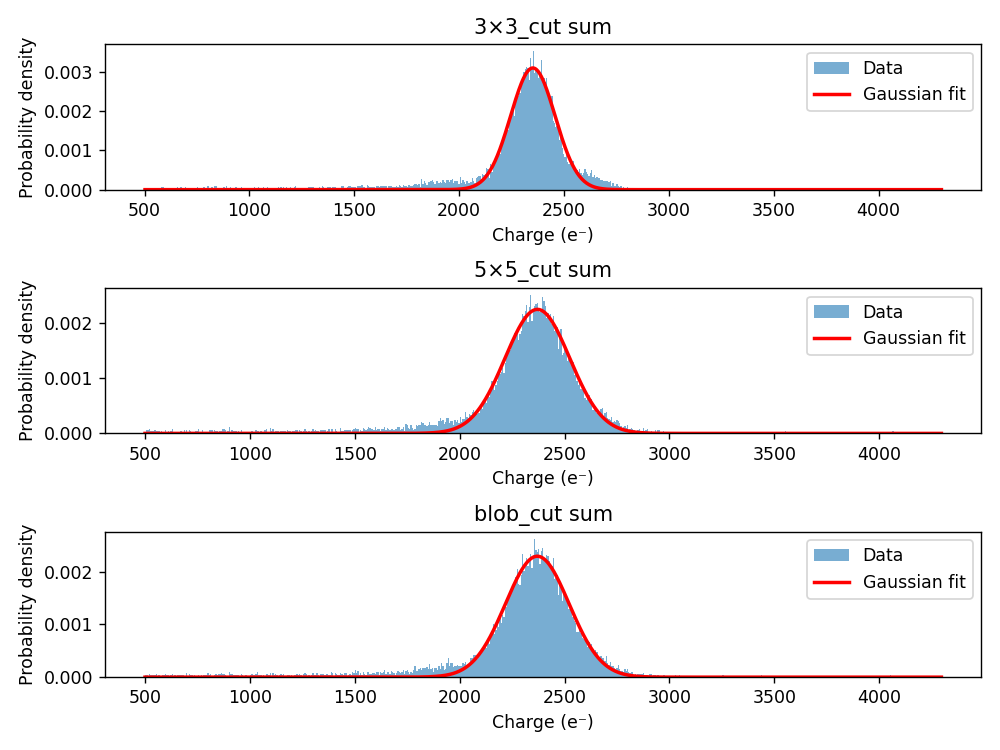

3×3_cut sum → μ = 2351.34 e⁻, σ = 105.95 e⁻, FWHM = 249.49 e⁻
5×5_cut sum → μ = 2370.68 e⁻, σ = 154.33 e⁻, FWHM = 363.43 e⁻
blob_cut sum → μ = 2370.00 e⁻, σ = 151.76 e⁻, FWHM = 357.37 e⁻
3x3 Data:   ⟨N⟩ = 2283.29, Var = 130878.57, Fano = 57.320
3x3 Fit:    ⟨N⟩ = 2351.34, Var = 11224.77, Fano = 4.774

5x5 Data:   ⟨N⟩ = 2298.69, Var = 143026.09, Fano = 62.221
5x5 Fit:    ⟨N⟩ = 2370.68, Var = 23818.49, Fano = 10.047

Blob Data:   ⟨N⟩ = 2298.44, Var = 140593.31, Fano = 61.169
Blob Fit:    ⟨N⟩ = 2370.00, Var = 23031.61, Fano = 9.718



In [14]:
# Define cut range
cut_min = 500
cut_max = 4300

# Apply cuts to the 3×3 data
data_3x3 = df['sum3x3_e⁻']
data_3x3_cut = data_3x3[(data_3x3 >= cut_min) & (data_3x3 <= cut_max)]

three_mean_data = data_3x3_cut.mean()
three_var_data  = data_3x3_cut.var(ddof=0) 
three_fano_data = three_var_data / three_mean_data

# Apply cuts to the 5×5 data
data_5x5 = df['sum5x5_e⁻']
data_5x5_cut = data_5x5[(data_5x5 >= cut_min) & (data_5x5 <= cut_max)]

five_mean_data = data_5x5_cut.mean()
five_var_data  = data_5x5_cut.var(ddof=0)
five_fano_data = five_var_data / five_mean_data

# Apply cuts to the blob data
data_blob = df['blob_e⁻']
data_blob_cut = data_blob[(data_blob >= cut_min) & (data_blob <= cut_max)]

blob_mean_data = data_blob_cut.mean()
blob_var_data  = data_blob_cut.var(ddof=0) 
blob_fano_data = blob_var_data / blob_mean_data


num_of_bins = 600

series = [
    ('3×3_cut sum', data_3x3_cut),
    ('5×5_cut sum', data_5x5_cut),
    ('blob_cut sum', data_blob_cut)
]

# make a figure with two subplots
fig, axes = plt.subplots(3, 1, figsize=(8, 6))
stats = []
for ax, (label, data_series) in zip(axes, series):
    # 1) build histogram
    counts, bin_edges = np.histogram(data_series, bins=num_of_bins, density=True)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # 2) initial guess [A, μ, σ]
    p0 = [counts.max(), data_series.mean(), data_series.std()]
    
    # 3) fit
    popt, _ = curve_fit(gaussian, bin_centers, counts, p0=p0)
    A_fit, mu_fit, sigma_fit = popt
    sigma_fit = abs(sigma_fit)
    
    # 4) FWHM
    fwhm = 2 * np.sqrt(2 * np.log(2)) * sigma_fit
    
    # 5) print fit parameters
    print(f"{label:8s} → μ = {mu_fit:.2f} e⁻, σ = {sigma_fit:.2f} e⁻, FWHM = {fwhm:.2f} e⁻")
    stats.append((mu_fit,sigma_fit,fwhm))
    # 6) plot histogram + fit
    ax.hist(data_series, bins=num_of_bins, density=True, alpha=0.6, label='Data')
    x_fit = np.linspace(bin_edges[0], bin_edges[-1], 1000)
    ax.plot(x_fit, gaussian(x_fit, *popt), 'r-', lw=2, label='Gaussian fit')
    ax.set(
        title=label,
        xlabel='Charge (e⁻)',
        ylabel='Probability density'
    )
    ax.legend()

plt.tight_layout()
plt.show()

three_mean_fit = stats[0][0]
three_var_fit = stats[0][1]**2
three_fano_fit = three_var_fit / three_mean_fit
five_mean_fit = stats[1][0]
five_var_fit = stats[1][1]**2
five_fano_fit = five_var_fit / five_mean_fit
blob_mean_fit = stats[2][0]
blob_var_fit = stats[2][1]**2
blob_fano_fit = blob_var_fit / blob_mean_fit

print(f"3x3 Data:   ⟨N⟩ = {three_mean_data:.2f}, Var = {three_var_data:.2f}, Fano = {three_fano_data:.3f}")
print(f"3x3 Fit:    ⟨N⟩ = {three_mean_fit:.2f}, Var = {three_var_fit:.2f}, Fano = {three_fano_fit:.3f}\n")

print(f"5x5 Data:   ⟨N⟩ = {five_mean_data:.2f}, Var = {five_var_data:.2f}, Fano = {five_fano_data:.3f}")
print(f"5x5 Fit:    ⟨N⟩ = {five_mean_fit:.2f}, Var = {five_var_fit:.2f}, Fano = {five_fano_fit:.3f}\n")

print(f"Blob Data:   ⟨N⟩ = {blob_mean_data:.2f}, Var = {blob_var_data:.2f}, Fano = {blob_fano_data:.3f}")
print(f"Blob Fit:    ⟨N⟩ = {blob_mean_fit:.2f}, Var = {blob_var_fit:.2f}, Fano = {blob_fano_fit:.3f}\n")

In [15]:
sigma_nn = np.sqrt(three_var_fit - read_noise_sigma**2)
print(f'If we remove the read noise from our distribution, the new σ = {sigma_nn} e-')

fano_nn = (sigma_nn**2) / three_mean_fit

print(f'The fano factor with noise remove is F = {fano_nn}')

If we remove the read noise from our distribution, the new σ = 87.90286262006046 e-
The fano factor with noise remove is F = 3.2861807331789863


In [16]:
best_w = xray_en/three_mean_fit
best_f_eff = fano_nn

print(f"Best fit of w = {best_w:.3f}")
print(f"Best fit of F_eff = {best_f_eff:.3f}")

Best fit of w = 2.509
Best fit of F_eff = 3.286


Three‐peak fit results:
  Peak 1: A1=0.00, μ1=1957.20 e⁻
  Peak 2: A2=0.00, μ2=2349.12 e⁻
  Peak 3: A3=0.00, μ3=2641.12 e⁻
  Common σ = 99.34 e⁻


<IPython.core.display.Javascript object>


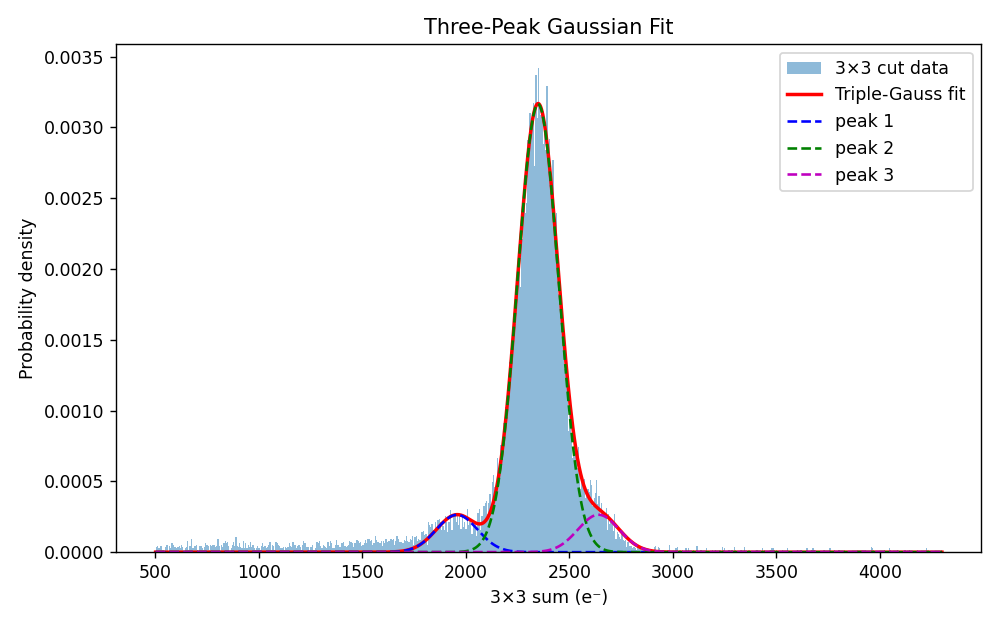

In [17]:
# 1) your 3×3-cut data array
x_data = data_3x3_cut.values

# 2) histogram density
num_of_bins = 650
counts, bin_edges = np.histogram(x_data, bins=num_of_bins, density=True)
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])

# 3) data mean & std for initial guesses
mu_data    = x_data.mean()
sigma_data = x_data.std()
d          = sigma_data  # a separation scale

# 4) define triple‐Gaussian
def triple_gauss(x,
                  A1, mu1,
                  A2, mu2,
                  A3, mu3,
                  sigma):
    g1 = A1 * np.exp(-0.5*((x - mu1)/sigma)**2)
    g2 = A2 * np.exp(-0.5*((x - mu2)/sigma)**2)
    g3 = A3 * np.exp(-0.5*((x - mu3)/sigma)**2)
    return g1 + g2 + g3

# 5) initial guesses:
#    split the total amplitude roughly in thirds,
#    put means at μ−d, μ, μ+d, and width ~σ
p0 = [
    counts.max()/3, mu_data - d,
    counts.max()/3, mu_data,
    counts.max()/3, mu_data + d,
    sigma_data
]
# 6) bounds: all amplitudes & sigma >0, means within data range
lo = [0,      mu_data-2*d,  0,      mu_data-2*d,  0,      mu_data-2*d,   0]
hi = [np.inf, mu_data+2*d,  np.inf, mu_data+2*d,  np.inf, mu_data+2*d, np.inf]

# 7) do the fit
popt, pcov = curve_fit(
    triple_gauss,
    bin_centers, counts,
    p0=p0, bounds=(lo, hi)
)
A1, mu1, A2, mu2, A3, mu3, sigma = popt

# 8) report your results
print("Three‐peak fit results:")
print(f"  Peak 1: A1={A1:.2f}, μ1={mu1:.2f} e⁻")
print(f"  Peak 2: A2={A2:.2f}, μ2={mu2:.2f} e⁻")
print(f"  Peak 3: A3={A3:.2f}, μ3={mu3:.2f} e⁻")
print(f"  Common σ = {sigma:.2f} e⁻")

# 9) plot data + fit + components
x_fit = np.linspace(bin_edges[0], bin_edges[-1], 1000)
y_fit = triple_gauss(x_fit, *popt)

plt.figure(figsize=(8,5))
plt.hist(x_data, bins=num_of_bins, density=True,
         alpha=0.5, label='3×3 cut data')
plt.plot(x_fit, y_fit, 'r-', lw=2, label='Triple‐Gauss fit')

# each sub‐peak
plt.plot(x_fit, A1*np.exp(-0.5*((x_fit-mu1)/sigma)**2),
         'b--', label='peak 1')
plt.plot(x_fit, A2*np.exp(-0.5*((x_fit-mu2)/sigma)**2),
         'g--', label='peak 2')
plt.plot(x_fit, A3*np.exp(-0.5*((x_fit-mu3)/sigma)**2),
         'm--', label='peak 3')

plt.xlabel("3×3 sum (e⁻)")
plt.ylabel("Probability density")
plt.title("Three‐Peak Gaussian Fit")
plt.legend()
plt.tight_layout()
plt.show()


In [18]:
sigma_nn = np.sqrt(sigma**2 - read_noise_sigma**2)
print(f'If we remove the read noise from our distribution, the new σ = {sigma_nn} e-')

fano_nn = (sigma_nn**2) / mu2

print(f'The fano factor with noise remove is F = {fano_nn}')

If we remove the read noise from our distribution, the new σ = 79.81486451152661 e-
The fano factor with noise remove is F = 2.711826683483212


Mean ionization events = 398.0, st. dev. ± 36.0


<IPython.core.display.Javascript object>


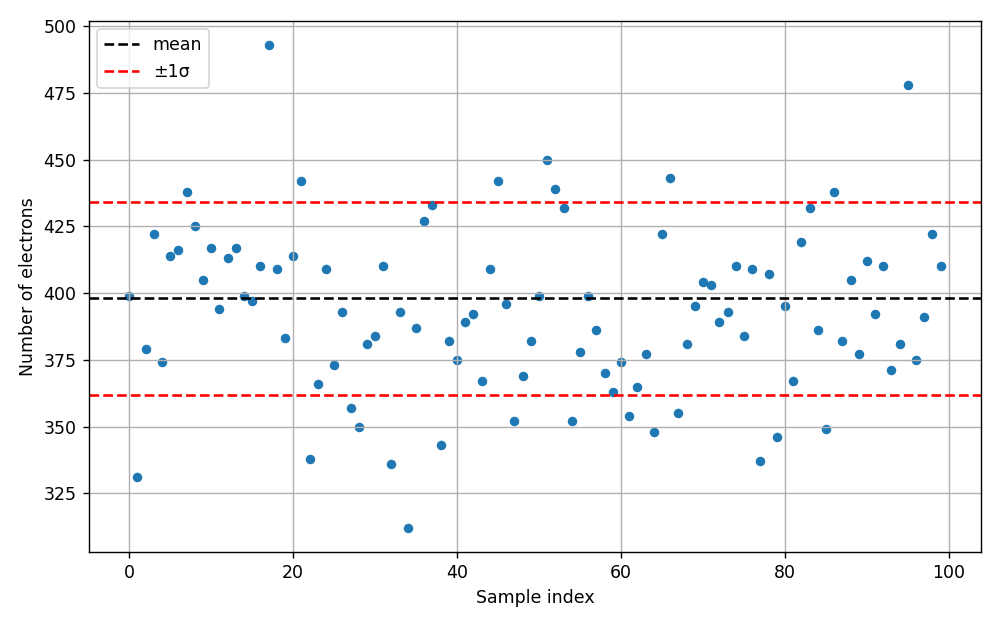

In [19]:
test_energy = 1000  # in eV

def T_to_elec_conversion(T, f_eff, w):
    mu_nb = T / w
    # NB parameters
    p = 1.0 / f_eff
    r = mu_nb * (p / (1.0 - p))  # = μ / (f_eff - 1)
    # sample one integer from NB(r, p)
    # note: .rvs supports non‐integer r
    return nbinom(r, p).rvs()

# draw 100 samples
samples = [T_to_elec_conversion(test_energy, best_f_eff, best_w)
           for _ in range(100)]

mu_nb = int(test_energy / best_w)
sigma_nb = int(np.sqrt(best_f_eff * mu_nb))
print(f"Mean ionization events = {mu_nb:.1f}, st. dev. ± {sigma_nb:.1f}")

# scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(range(len(samples)), samples, s=20)
plt.axhline(mu_nb, linestyle='--', color='k', label='mean')
plt.axhline(mu_nb - sigma_nb, linestyle='--', color='r', label='±1σ')
plt.axhline(mu_nb + sigma_nb, linestyle='--', color='r')
plt.xlabel('Sample index')
plt.ylabel('Number of electrons')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
